# Basic text analytics: counting words

In this notebook, you will learn:
1. how to prepare text data for analysis
2. how to derive word frequency information for a corpus (a collection of texts)
3. how to produce visualisations comparing the frequency of occurrence of words in two corpora

**Prerequisites**:
1. basic familiarity with R
3. The following R packages installed: **tm, NLP, stringi, magrittr, ggplot2**

### What's in a word?

The title above includes the phrase *counting words* - but what does *word* mean here? How would you define *word*?

To get a sense of the problem, think about the following question:

*How many words are there in the sentence '**The cat sat on the mat**'?*

There are two reasonable answers to this question:
- Answer 1: There are six words – six groups of characters separated in accordance with orthographic convention
- Answer 2: There are five words – five unique groups of characters and one of those occurs twice
Both answers are correct – but we are counting different things. The standard terms for these things are **tokens** and **types**.

Types are the unique entities on our sample. If we count types, we are not interested in how many times each type occurs; after we have included a type in our count, we ignore repetitions. If we count tokens, we do care how often each type occurs; we count each repetition of each type

We can also think about another question:

*Are 'dog' and dogs' the same word?*

They are distinct types – they are not identical and they have to be distinct tokens (if they occur in the same text).
But we still have an intuition that there is some abstract entity which includes both of them - for example, we would not expect a (monolingual) dictionary to have entries for both. The abstract entity goes by various names such as **lemma** and **listeme**. (We are not going to look at such entities today.)

### Getting set up
We will be using five R packages in this exercise: **tm** which provides tools for text mining, **NLP** which tm requires, **stringi** which provides string processing tools, **magrittr** which allows us to use pipe notation (more about this later), and **ggplot2** for some visualisation. We do not want R to treat bits of text as factors, so we set the option which prevents that. We will be working with the data files which you created in the first part of the workshop and we assume that these are still locally available.

In [1]:
# Set up if needed
#install.packages('NLP')
#install.packages('tm')
#install.packages('stringi')
#install.packages('magrittr')
#install.packages('ggplot2')

library("NLP")
library('tm')
library('stringi')
library('magrittr')
library('ggplot2')

# set options
options(stringsAsFactors = F)


Attaching package: ‘ggplot2’


The following object is masked from ‘package:NLP’:

    annotate




### Preparing the text
First, we have to make our text available for analysis. There are several preprocessing operations which are more or less standard in text analysis, but first we need to think about how these operations relate to twitter data.

The details of how text is tokenised vary from one tool to another. This means that in order to have *dog* and *dog,* treated as tokens of the same type, removing punctuation from text is sensible. This is normally done using a predefined list of punctuation characters such as this one:

! " # $ % & ' * + , . ) ( : ; < = > ? @ \ / ] [ ^ ` { | } ~

But this might be problematic for Twitter data! If we delete all punctuation from tweets, we will not be able to keep track of two important elements:
- Hashtags e.g. #auspol
- Handles e.g. @SimonMusgrave1

One solution would be to change the relevant punctuation to text, but this is a bit clunky. Another possibility is to not delete those two punctuation marks. Text handling packages (like **tm** and **OpenNLP**) come with predefined punctuation lists and (in theory) we can edit those lists. But in practice it can be hard to track them down and it is easier to write a line of code to do a customised deletion.

The next code cell does some basic cleaning operations on our data, such as getting rid of urls and new line characers (and a solution for the punctuation problem). We end by inspecting the data to make sure that we have the results we expect.

In [2]:
# read data as csv file, read text as vector, create corpus
# assumes data file is in the working directory
echidna <- read.csv("echidna_minimal.csv", header = TRUE, stringsAsFactors = FALSE, encoding = "UTF-8")
# remove urls
echidna$stripped_text <- gsub("http.*","",  echidna$text)
echidna$stripped_text <- gsub("https.*","", echidna$stripped_text)
# remove new lines
echidna$stripped_text <- gsub("\\n"," ", echidna$stripped_text, fixed = TRUE)
# punctuation 
echidna$stripped_text <- gsub("['.,!?\"*+%&;:<=>/)(^~`|)(}{]", "", echidna$stripped_text)

# inspect data
str(echidna)

'data.frame':	2869 obs. of  7 variables:
 $ id                            : num  1.46e+18 1.46e+18 1.46e+18 1.46e+18 1.46e+18 ...
 $ created_at                    : chr  "2021-11-05T04:13:44.000Z" "2021-11-05T03:59:04.000Z" "2021-11-05T03:54:40.000Z" "2021-11-05T03:53:52.000Z" ...
 $ author_id                     : num  1.25e+18 1.07e+18 8.89e+17 1.43e+18 1.33e+18 ...
 $ text                          : chr  "Image prediction: echidna\\nConfidence: 10.09%\\nSubmission by @xkmi_ https://t.co/MMZ3yfw8PY" "Echidna \U{01f5a4}(Re: Zero)\\n\\n[A portion of cool art] https://t.co/4v5E5BwRSg" "Jeff the Echidna" "For some reason, I found Knuckles the Echidna easier than Bob Charlie. https://t.co/C9MJp6TS7v" ...
 $ referenced_tweets.retweeted.id: num  1.46e+18 1.46e+18 NA NA NA ...
 $ public_metrics.like_count     : int  2467 644 0 0 0 1 0 111 1 1 ...
 $ stripped_text                 : chr  "Image prediction echidna Confidence 1009 Submission by @xkmi_ " "Echidna \U{01f5a4}Re Zero  [A portion of 

We also need to do something about emojis - they are part of the communicative resources of twitter and we don't want to just ignore them. The way we will do this is by replacing the emojis with their prose description. Notice that we have read in the data as UTF-8, i.e. Unicode encoding. We can search for the Unicode representations of emojis (which look like this: \U+1F928) and then recover the description from the look-up table we download. Those descriptions have spaces in them and we delete those - our counting procedures look at single tokens, so *smiling face* will not be recorded as a unit but *smilingface* will. (Note that even if we decided we were not interested in emojis - and that is a reasonable decision in some cases - we would still need to be able to identify them in order to delete them.)

The various search-and-replace operations in the previous and following code blocks use **regular expressions**. Regular expressions are a powerful way of specifying patterns of characters to be matched; if you would like to learn more about them, [this](http://solaris-8.tripod.com/regexp.pdf) is a good place to start.

The following code block also uses *piping*, mentioned above. The symbol **%>%** shows this - it can be read more or less as *and then*. So the first snippet which starts with *emoji* can be read as:
Take the object **emoji**, extract all the elements in that object which match the specified pattern, *and then* take the output of that operation and replace the specified pattern with nothing *and then* take the output of that operation and trim any space from the strings *and then* assign the output to the object **emoji.chars**.

In [3]:
# encoded emojis to prose descriptions
# read emoji info and get rid of documentation lines
readLines("https://unicode.org/Public/emoji/5.0/emoji-test.txt",
          encoding="UTF-8") %>%
  stri_subset_regex(pattern = "^[^#]") %>%
  stri_subset_regex(pattern = ".+") -> emoji

# get the emoji characters and clean them up
emoji %>%
  stri_extract_all_regex(pattern = "# *.{1,2} *") %>%
  stri_replace_all_fixed(pattern = c("*", "#"),
                         replacement = "",
                         vectorize_all=FALSE) %>%
  stri_trim_both() -> emoji.chars

# get the emoji character descriptions
emoji %>%
  stri_extract_all_regex(pattern = "#.*$") %>%
  stri_replace_all_regex(pattern = "# *.{1,2} *",
                         replacement = "") %>%
  stri_trim_both() -> emoji.descriptions
# collapse the descriptions
emoji.descriptions <- gsub(" ", '', emoji.descriptions, fixed = TRUE)

# Replace Unicode characters with prose descriptions
echidna$stripped_text <- stri_replace_all_regex(echidna$stripped_text, pattern = emoji.chars, replacement = paste(emoji.descriptions," "), vectorize_all=FALSE)

# inspect data
head(echidna$stripped_text)


[1] "Image prediction echidna Confidence 1009 Submission by @xkmi_ "          
[2] "Echidna blackheart  Re Zero  [A portion of cool art] "                   
[3] "Jeff the Echidna"                                                        
[4] "For some reason I found Knuckles the Echidna easier than Bob Charlie "   
[5] "Mara The Echidna by @JJackhog on "                                       
[6] "goodnight to everyone who likes echidna the rest of yougoodnight i guess"

### More preparation
Now we can do the kind of preparation which we might do for any text data. Creating a Corpus object via **tm** is a good way to do this; it means we can  use **tm** tools to do some pre-processing and we will use other **tm** tools to do the counting later.

Initially, we will apply four kinds of cleaning to our data:
1. Making all characters lower case; otherwise *dog* and *Dog* will be treated as distinct types.
2. Removing numbers; probably not important here, but e.g. page numbers can cause artefacts to appear in analyses
3. Removing whitespace other than single spaces between tokens.

(You will see some warning messages as this code runs - they are not important.)

In [4]:
# make corpus
echidna_corpus <- Corpus(VectorSource(echidna$stripped_text))

# all lower case, remove whitespace, numbers
echidna_corpus <- echidna_corpus %>% tm_map(content_transformer(tolower)) %>% tm_map(removeNumbers) %>% tm_map(stripWhitespace)


Warning message in tm_map.SimpleCorpus(., content_transformer(tolower)):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(., removeNumbers):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(., stripWhitespace):
“transformation drops documents”


### Doing some counting
Now we can get the most basic numbers for our corpus: how many tokens and how many types do we have? We will do this by creating a matrix where each row represents a document and each column represents a type. The number of columns is the number of types, and we can get the number of tokens either as the sum of the sums of each row or as the sum of the sums of each column.

In [5]:
# create document-term matrix
dtm <- DocumentTermMatrix(echidna_corpus)
# get word frequency list
# token count 
tokens1 <- sum(rowSums(as.matrix(dtm)))
print(paste0("Tokens: ", tokens1))
# collapse matrix by summing over columns
freq <- colSums(as.matrix(dtm))
# length should be total number of terms - type count
print(paste0('Types: ',length(freq)))

[1] "Tokens: 39317"
[1] "Types: 7023"


### Looking at frequency
Now we can look at what are the most frequently occurring types in our corpus. We already have the column sums, the number of tokens for each type, in the matrix object ``freq``. Now we sort the matrix in descending order and view the 20 most frequent types.

In [6]:
# create sort order (descending)
ord <- order(freq,decreasing=TRUE)
# List top 20 terms in decreasing order of freq
freq[ord][0:20]


echidna           the           and           for           you 
         2266          1750           880           477           344 
     knuckles @lady_echidna          this          with          that 
          304           299           251           251           230 
  orangeheart           but          from          cool    blackheart 
          217           216           201           189           184 
          not          art]       portion          like          more 
          177           174           174           167           162

### Function words and content words
These results are what we would expect to see for most samples of English text: function words like *the* and *and* are very common. The 20 most frequent words in the British National Corpus are *the, of, and, a, in, to, it, is, was, to, i, for, you, he, be, with, on, that, by, at*, all function words. 

Are there differences between the BNC list and the most frequent words in our data? Can we make any sense of these differences?

In text analysis, it is very common to use a **stop list**, that is a list of words which will be removed from the corpus before any analysis is performed. We will apply a stop list to our corpus and see what difference this makes to the list of most frequent words. (You can ignore the warning message again)

In [7]:
# remove stopwords
docs1_stop <- tm_map(echidna_corpus, removeWords, stopwords("english"))
dtm <- DocumentTermMatrix(docs1_stop)
freq <- colSums(as.matrix(dtm))
ord <- order(freq,decreasing=TRUE)
freq[ord][0:20]

Warning message in tm_map.SimpleCorpus(echidna_corpus, removeWords, stopwords("english")):
“transformation drops documents”


echidna      knuckles @lady_echidna   orangeheart          cool 
         2266           304           299           217           189 
   blackheart          art]       portion          like         sonic 
          184           174           174           167           161 
         zero         image           can          just        @xkmi_ 
          144           141           112           108           104 
   confidence    prediction    submission        rezero           que 
          104           104           104            99            96

### Comparing frequency
We want to compare frequencies across two corpora, but we cannot do this by just comparing the counts directly because the corpora may differ in size. We expect that there will be more tokens of a given type in a larger corpus than in a smaller corpus just because of the difference in size, but we are interested in the relative frequency of types in the two corpora. To make this comparison possible, we need to **normalise** our frequency counts to some fixed number of tokens. Here, we will normalise frequency per 100k tokens. We also save the data for the 20 most common types as a data frame - we will use this when we make a visual comparison of the two text collections.

In [8]:
# make freq a data frame, add normalised freq
types <- names(freq)
freq_df <- data.frame(types, freq)
ord_freq_C1 <- freq_df[order(freq, decreasing = TRUE),]
ord_freq_C1['norm_freq'] <- ord_freq_C1$freq/(tokens1/100000)
ord_freq_C1[0:20,]
# store top 20 words for future use
top20_echidna <- ord_freq_C1[0:20,]

,types,freq,norm_freq
,<chr>,<dbl>,<dbl>
echidna,echidna,2266,5763.4102
knuckles,knuckles,304,773.2024
@lady_echidna,@lady_echidna,299,760.4853
orangeheart,orangeheart,217,551.9241
cool,cool,189,480.7081
blackheart,blackheart,184,467.9909
art],art],174,442.5567
portion,portion,174,442.5567
like,like,167,424.7527


### Getting data from the second corpus

Now, we will repeat our procedures for the second corpus - we won't bother with showing the frequent types without the stop list. 

In [9]:
# corpus2
# read data as csv file, read text as vector, create corpus
platypus <- read.csv("platypus_minimal.csv", header = TRUE, stringsAsFactors = FALSE, encoding = "UTF-8")
# remove urls
platypus$stripped_text <- gsub("http.*","",  platypus$text)
platypus$stripped_text <- gsub("https.*","", platypus$stripped_text)
# remove new lines
platypus$stripped_text <- gsub("\\n"," ", platypus$stripped_text, fixed = TRUE)
# change # and @ to text 
platypus$stripped_text <- gsub("#","HASH", platypus$stripped_text)
platypus$stripped_text <- gsub("@","AT", platypus$stripped_text)

platypus$stripped_text <- stri_replace_all_regex(platypus$stripped_text, pattern = emoji.chars, replacement = paste(emoji.descriptions," "), vectorize_all=FALSE)

# make corpus
platypus_corpus <- Corpus(VectorSource(platypus$stripped_text))

# all lower case,remove punctuation, numbers
platypus_corpus <- platypus_corpus %>% tm_map(content_transformer(tolower)) %>% tm_map(removeNumbers) %>% tm_map(stripWhitespace)

# create document-term matrix
dtm <- DocumentTermMatrix(platypus_corpus)
#get word frequency list
# token count 
tokens2 <- sum(rowSums(as.matrix(dtm)))
print(paste0("Tokens: ", tokens2))
# remove stopwords
docs2_stop <- tm_map(platypus_corpus, removeWords, stopwords("english"))
# create document-term matrix
dtm <- DocumentTermMatrix(docs2_stop)
# collapse matrix by summing over columns
freq <- colSums(as.matrix(dtm))
# length should be total number of terms - type count
print(paste0('Types: ',length(freq)))
# create sort order (descending)
ord <- order(freq,decreasing=TRUE)
# make freq a data frame, add normalised freq
types <- names(freq)
freq_df <- data.frame(types, freq)
ord_freq_C2 <- freq_df[order(freq, decreasing = TRUE),]
ord_freq_C2['norm_freq'] <- ord_freq_C2$freq/(tokens2/100000)
ord_freq_C2[0:20,]
# inspect data
top20_C2 <- ord_freq_C2[0:20,]

Warning message in tm_map.SimpleCorpus(., content_transformer(tolower)):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(., removeNumbers):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(., stripWhitespace):
“transformation drops documents”


[1] "Tokens: 77056"


Warning message in tm_map.SimpleCorpus(platypus_corpus, removeWords, stopwords("english")):
“transformation drops documents”


[1] "Types: 11827"


,types,freq,norm_freq
,<chr>,<dbl>,<dbl>
platypus,platypus,3390,4399.3978
perry,perry,1269,1646.8542
baby,baby,560,726.7442
keycap:#,keycap:#,555,720.2554
like,like,552,716.3621
puts,puts,538,698.1935
"""perry","""perry",535,694.3002
wrappedgift,wrappedgift,513,665.7496
fire,fire,486,630.7101


### Making a visualisation
The lists of 20 most frequent types overlap a little, but they are certainly not identical. We want to include all the words from both lists, so we combine them and then use the ``unique()`` function to get rid of duplicates. Two bar charts side by side is one way to visualise this data; the R base function ``barplot()`` will do this, but it needs the data as rows of a table.

In [10]:
# combine the two lists of common types
types_combined <- top20_echidna['types']
types_combined <- rbind(types_combined, top20_C2['types'])
types_combined <- unique(types_combined)
# make a matrix with the frequency data in two rows
rows <- nrow(types_combined)
bar_data <- matrix(1:rows*2, nrow = 2, ncol = rows)
# get the normalised frequency values
for (i in 1:rows) {
    word <- types_combined[i,1]
    freq_1 <- subset(ord_freq_C1, types == word)[3]
    bar_data[1,i] <- freq_1[1,1]
    freq_2 <- subset(ord_freq_C2, types == word)[3]
    bar_data[2,i] <- freq_2[1,1]
    }

rows <- c('C1', 'C2')
columns <- types_combined[,1]
rownames(bar_data) <- rows
colnames(bar_data) <- columns
# inspect data
bar_data

,echidna,knuckles,@lady_echidna,orangeheart,cool,blackheart,art],portion,like,sonic,⋯,platypus:,god:,know,called,&amp;,one,"platypus?""",doofenschmirtz:,"platypus??""",fedora:
C1,5763.410230,773.202432,760.4853,551.924104,480.70809,467.99095,442.55665,442.5567,424.7527,409.49208,⋯,NA,NA,127.1715,17.8040,NA,190.7572,NA,NA,NA,NA
C2,6.488787,1.297757,NA,2.595515,27.25291,5.19103,49.31478,NA,716.3621,33.74169,⋯,602.1595,577.5021,532.0806,439.9398,397.1138,363.3721,352.99,343.9057,343.9057,342.608


We need to display the types vertically or we won't be able to see them all. Some of them are quite long words, so we reset the lower margin to make sure all of the characters will be visible. We also use the ``las`` parameter to make the text on each axis perpendicular to the axis. And then all that is left to do is to choose some colours that you like!

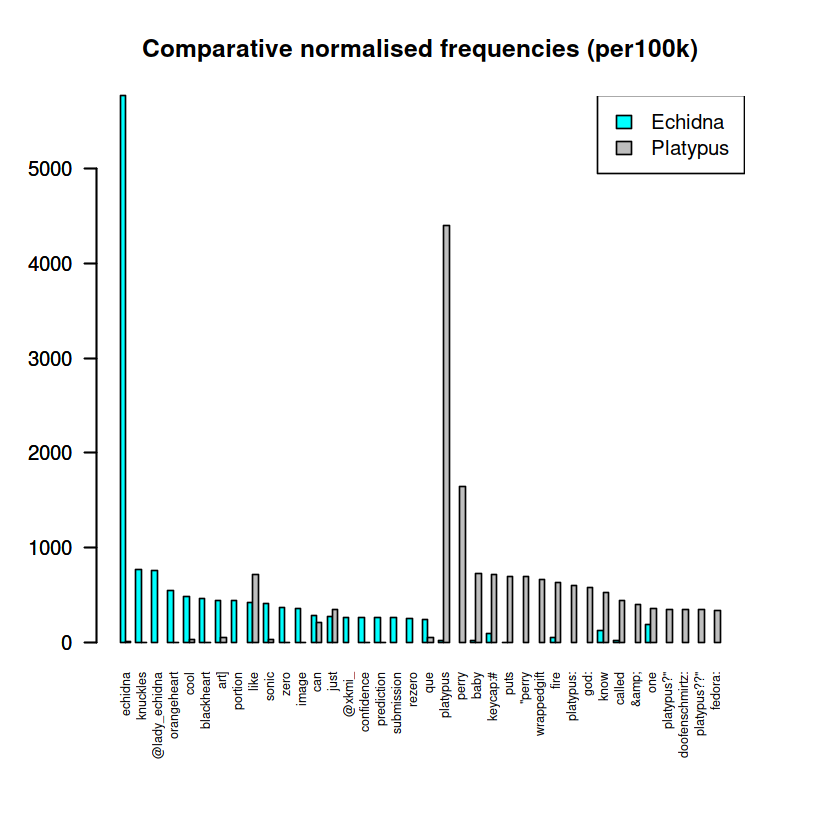

In [11]:
# set bottom margin to fit long words
options(jupyter.plot_scale=1)
par(mar=c(8,4,4,4))
barplot(bar_data, beside = TRUE, las = 2, cex.names = 0.6,
main = "Comparative normalised frequencies (per100k)", col = c("cyan","grey"))
legend("topright",
c("Echidna","Platypus"),
fill = c("cyan","grey"))
axis(2, las=1)

### Another visualisation

The figure we have just produced is informative, but having the bars for each corpus side by side may be even more useful. To produce a plot of this type, we will use the ``ggplot2`` package, which is widely used in preference to R base plot functions. But ``ggplot2`` needs the data in a different shape! We need a data frame (a table) where each row includes a word (a type), the corpus from which the data comes, and the frequency. The next code block does this reshaping and shows you the result.

In [15]:
# another visualisation

# make doubled list of types
double <- function(name) {c(name,name)}
doubles <- lapply(types_combined$types, double)
doubles_flat <- do.call(c, doubles)

# make column for source corpus
corpora <- c('E', 'P')
data_col <- rep(corpora, times = length(types_combined$types))

# make list of frequencies
freq_list <- list()

for (i in 1:length(types_combined$types)) {
    freq_list <- c(freq_list, bar_data[1,i], bar_data[2,i])
}
# remove N
freq_list[is.na(freq_list)] <- 0

# assemble data frame
ggplot_data <- data.frame(doubles_flat, data_col, unlist(freq_list))
colnames(ggplot_data) <- c('type', 'corpus', 'freq')
ggplot_data

type,corpus,freq
<chr>,<chr>,<dbl>
echidna,E,5763.410230
echidna,P,6.488787
knuckles,E,773.202432
knuckles,P,1.297757
@lady_echidna,E,760.485286
@lady_echidna,P,0.000000
orangeheart,E,551.924104
orangeheart,P,2.595515
cool,E,480.708091


Now we can make the visualisation. The syntax of ``ggplot`` is not transparent, but there are a two points to be aware of here. First, the section ``aes(x = type, y = freq, fill = corpus)`` specifies how the data will be plotted: the types (words) will be on the x axis, the frequencies will be on the y axis and the data will be grouped by the source corpus. (Actually, the code tells ggplot to assign fill colour to the bars depending on the source corpus.) Secondly, the section of code starting with ``theme`` tells ``ggplot`` to rotate the x-axis labels so that we can read them. We could specify colours for the fill, but ``ggplot`` has quite good taste in this respect.

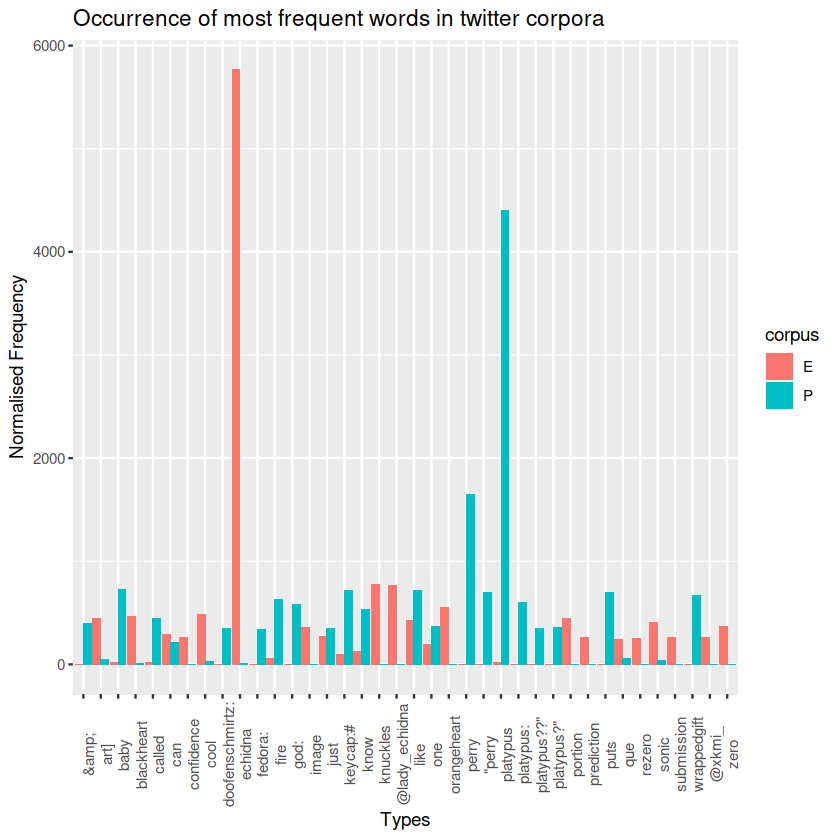

In [16]:
# make side-by-side bar chart

gg <- ggplot(ggplot_data)
gg <- gg + geom_bar(aes(x = type, y = freq, fill = corpus), position="dodge", stat = "identity") + theme(axis.text.x = element_text(angle = 90))
gg <- gg + labs(x="Types",y="Normalised Frequency")+
  ggtitle(paste("Occurrence of most frequent words in twitter corpora"))
print(gg)

### Outro

Extract session information

In [ ]:
sessionInfo()